<a href="https://colab.research.google.com/github/SpaceTimeNarratives/demo/blob/main/spatial_narrative_demo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a dataset from corpus

### Corpus files

These are sample .xml files from the [Corpus of the Lake District Writing](https://www.lancaster.ac.uk/fass/projects/spatialhum.wordpress/?page_id=64#:~:text=The%20Corpus%20of%20Lake%20District,Poly%2DOlbion%20(1622).). They are annotated with important features for a previous project which could be relevant for us in future. However, we want to build a method that works on plain text too.

Execute the code below to clone (download) the materials in `demo`, change into the `corpus` folder and view the list of files in the `files` folder:

In [1]:
!git clone https://github.com/SpaceTimeNarratives/demo.git

Cloning into 'demo'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 450 (delta 50), reused 80 (delta 18), pack-reused 324
Receiving objects: 100% (450/450), 40.01 MiB | 27.40 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [2]:
cd demo/corpus/

/content/demo/corpus


In [3]:
ls files

Anon_cqp_66.xml         Denholm_cqp_35.xml    Southey_cqp_40.xml
Bree_cqp_56.xml         Gell_cqp_29.xml       Walker_cqp_25.xml
Carter_cqp_52.xml       Hawthorne_cqp_70.xml
Collingwood_cqp_75.xml  Ostell_cqp_34.xml


You can also see what the content of the files look like by looking at one of them `Anon_cqp_66.xml`

In [4]:
!head files/Anon_cqp_66.xml

<?xml version="1.0" encoding="UTF-8"?><document>

<text id="1857_b"><p><s id="s1">The English Lakes.</s> </p>

<p><s id="s2">Introduction.</s> </p>

<p><s id="s3">By the route which we have traced among the English Lakes in the following pages, we believe that the traveller may visit all the chief points of interest in the shortest space of time, while those who have their time more at command may extend their excursions to secondary points of interest by following the various diverging routes headed in italics. We have selected <enamex sw="w420" long="-2.75205279814005" lat="54.66713013349954" type="ppl" gazref="unlock:11243307" name="Penrith" conf="2.6">Penrith</enamex> as the starting point, because Ulleswater, one of the finest of the lakes, is seen to greatest advantage by being approached from this direction, while it is as convenient a quarter as any of the others from which to set out on a tour through the district.</s></p>

<p><s id="s4">With the carefully prepared map attache

Let's write a function `clean_text()` to remove the tags and return 'cleaned' text.

In [5]:
from bs4 import BeautifulSoup
import re

In [6]:
# cleans the text of tags and punctuations. Assumes .xml file
def clean_text(input_text):
  soup = BeautifulSoup(input_text, 'xml')
  # Define a regular expression pattern to match XML tags
  pattern = re.compile(r'<.*?>')
  _text = re.sub(pattern, '', input_text)

  # use the nltk sentence tokenizer to segment the text into sentences
  _text = _text.replace('\n', ' ').replace('\t', ' ').replace('∫', 's')
  _text = re.sub(r'\s+', ' ', _text)
  return _text.strip()

Now, let's open and read the file `Anon_cqp_66.xml` and pass it to the `clean_text()` function

In [7]:
filename = 'Anon_cqp_66.xml'
clean_text(open(f'files/{filename}').read())

'The English Lakes. Introduction. By the route which we have traced among the English Lakes in the following pages, we believe that the traveller may visit all the chief points of interest in the shortest space of time, while those who have their time more at command may extend their excursions to secondary points of interest by following the various diverging routes headed in italics. We have selected Penrith as the starting point, because Ulleswater, one of the finest of the lakes, is seen to greatest advantage by being approached from this direction, while it is as convenient a quarter as any of the others from which to set out on a tour through the district. With the carefully prepared map attached to this guide, the tourist will experience no difficulty in tracing the main route and the diverging excursions here laid down; and a very little consideration, with the aid of occasional inquiry as to minutiae when on the spot, will enable him to vary his proceedings according to inclin

### Processing the corpus file

Here we want present the content of the file in a data table. Each row will represent a sentence while the columns will be the relevant details e.g. `sent_id`, `text`, `place names`(and the positions in text). `geo feature nouns`, `locative adverbs`, `spatial prepositions` etc.

We can also include a column for the `sentiment score` on the text.


Install required libraries...

In [8]:
pip -q install -r resources/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 13.9 MB/s eta 0:00:00


Let's pass all the corpus files through the `clean_text()` function and store the outputs for each file in a dictionary `clean_texts`

In [9]:
import os
cleaned_texts = {f: clean_text(open(f"files/{f}").read())
                for f in os.listdir('files/') if f.endswith('.xml')}

Run the function file for the required functions

In [10]:
%run resources/functions.py

Load all the lists for the entity categories

In [11]:
# Get the list of placenames and geonouns
place_names = [name.strip().title().replace("'S", "'s") for name in open('resources/LD_placenames.txt').readlines()] #read and convert to title case
place_names += [name.upper() for name in place_names] #retain the upper case versions
geonouns = get_inflections([noun.strip() for noun in open('resources/geo_feature_nouns.txt').readlines()])

# Get the locative adverbs
loc_advs = [l.split()[0] for l in open('resources/locative_adverbs.txt').readlines()]
sp_prep  = [l.strip() for l in open('resources/spatial_prepositions.txt').readlines()
                                                            if len(l.strip())>2]
# Get distances
distances = [l.strip() for l in open('resources/distances.txt').readlines()]

# Get dates
dates     = [l.strip() for l in open('resources/dates.txt').readlines()]

# Get times
times     = [l.strip() for l in open('resources/times.txt').readlines()]

# Get events
events    = [l.strip() for l in open('resources/events.txt').readlines()]

# Get the list of positive and negative words from the sentiment lexicon
pos_words = [w.strip() for w in open('resources/positive-words.txt','r', encoding='latin-1').readlines()[35:]]
neg_words = [w.strip() for w in open('resources/negative-words.txt','r', encoding='latin-1').readlines()[35:]]

Load the `Spacy`'s small English model and modify the `ner` rules by adding our patterns to pipeline with `Entity Ruler`

### Building the model for extracting spatial entities

Let's build the `Spacy`'s `ner EntityRuler`. We need to install the required libraries from the `requirements.txt`, then load and process the necessary files from the `resources` folder.

In [12]:
# Alternatively, load the small spacy English model
import spacy
nlp = spacy.load("en_core_web_sm")

# Add the `entity_ruler` to the pipeline before the NER module
ruler = nlp.add_pipe("entity_ruler", before='ner')


# Define the patterns for the EntityRuler by labelling all the names with the tag PLNAME
patterns =  [{"label": "PLNAME",  "pattern": plname} for plname in set(place_names)]
patterns += [{"label": "GEONOUN", "pattern": noun} for noun in geonouns]
patterns += [{"label": "+EMOTION", "pattern": word} for word in pos_words]
patterns += [{"label": "-EMOTION", "pattern": word} for word in neg_words]
patterns += [{"label": "EVENT",   "pattern": word} for word in events]
patterns += [{"label": "DATE", "pattern": word} for word in dates]
patterns += [{"label": "TIME", "pattern": word} for word in times]
patterns += [{"label": "DISTANCE", "pattern": word} for word in distances]
patterns += [{"label": "LOCADV", "pattern": word} for word in loc_advs]
patterns += [{"label": "SP-PREP", "pattern": word} for word in sp_prep]

ruler.add_patterns(patterns)

Let's define a tag name for each entity category

In [13]:
header_tag = [('plnames', 'PLNAME'), ('geonouns', 'GEONOUN'), ('pos_words', '+EMOTION'),
              ('neg_words', '-EMOTION'), ('events', 'EVENT'), ('dates', 'DATE'),
              ('times', 	'TIME'), ('distances', 'DISTANCE'), ('loc_advs', 'LOCADV'),
              ('spa_preps', 'SP-PREP')]

# keep all the tags here...
tags = [tag for _, tag in header_tag]

# label the entity span with the right tag
tagger = lambda d, t: [(ent,ent.start_char, ent.end_char) for ent in d.ents if ent.label_==t]

Import `nltk` and `pandas`, then define the `generate_sent_dataset()` function. `tqdm` will help us to monitor the progress of the process.

Also, we need the `pre_process_text()` function to lemmatize words, remove stopwords and punctuations while computing the sentiments.

In [14]:
import nltk
from tqdm.notebook import tqdm
import pandas as pd
import string

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
def pre_process_text(text):
  return list(filter(lambda token: token not in string.punctuation,
             [lemma.lemmatize(word) for word in word_tokenize(text)
             if word.lower() not in stop_words]))

In [16]:
def generate_sent_dataset(filename):
  # define an empty pandas dataframe
  data_df = pd.DataFrame.from_dict({})

  # for each category, create an empty list for storing all extracted entitites
  header_list = {header:[] for header, _ in header_tag}

  # store the sentence ids and sentences
  id_sents = zip(*[(sentID,sent.strip()) for sentID, sent in
            enumerate(sent_tokenize(cleaned_texts[filename]))])

  data_df['sent_id'], data_df['sentence'] = list(id_sents)

  # Extract and store all entity categories found in each sentence
  pbar = tqdm(enumerate(data_df['sentence']))
  for i, sent in pbar:
    doc = nlp(sent)
    for header, tag in header_tag: header_list[header].append(tagger(doc, tag))
    pbar.set_description(f"-{filename[:-4]} sent {i:003d}")

  for header, tag in header_tag: data_df[header]=header_list[header]

  # include sentiment scores
  data_df['sentiment_score']= (data_df['pos_words'].apply(len) - data_df['neg_words'
                                        ].apply(len))/data_df['sentence'].apply(
                                            lambda x : len(pre_process_text(x)))

  return data_df

### Generating and exploring the datasets from files

Generating all the datasets for all the corpus files. May take a while to complete...

In [17]:
data_tables = {f:generate_sent_dataset(f) for f in sorted(cleaned_texts.keys())}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Let's look at the top 5 rows of one of the files `'Anon_cqp_66.xml'`...


In [18]:
data_tables['Anon_cqp_66.xml'].head()

,sent_id,sentence,plnames,geonouns,pos_words,neg_words,events,dates,times,distances,loc_advs,spa_preps,sentiment_score
0,0,The English Lakes.,"[((The, English, Lakes), 0, 17)]",[],[],[],[],[],[],[],[],[],0.000000
1,1,Introduction.,[],[],[],[],[],[],[],[],[],[],0.000000
2,2,By the route which we have traced among the En...,"[((English, Lakes), 44, 57)]","[((points), 136, 142), ((points), 275, 281)]",[],[],[],[],[],[],[],"[((among), 34, 39)]",0.000000
3,3,We have selected Penrith as the starting point...,"[((Penrith), 17, 24), ((Ulleswater), 56, 66)]","[((point), 41, 46), ((lakes), 93, 98), ((distr...","[((finest), 79, 85), ((greatest), 111, 119), (...",[],[],"[((a, quarter), 197, 206)]",[],[],[],"[((out), 246, 249), ((through), 260, 267)]",0.210526
4,4,With the carefully prepared map attached to th...,[],[],[],"[((difficulty), 87, 97)]",[],[],[],[],"[((here), 153, 157)]","[((down), 163, 167)]",-0.038462


#### Plot the sentiments on the sentences

In [19]:
import numpy as np
import matplotlib

In [20]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","lightgreen", "green"])
normalize = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [21]:
def plot_sentiments(filename):
  data = data_tables[filename]
  data['norm_sentiment'] = normalize(data['sentiment_score'])
  data.plot.scatter('sent_id', 'norm_sentiment', c='norm_sentiment', colormap=cmap, figsize=(10, 5))

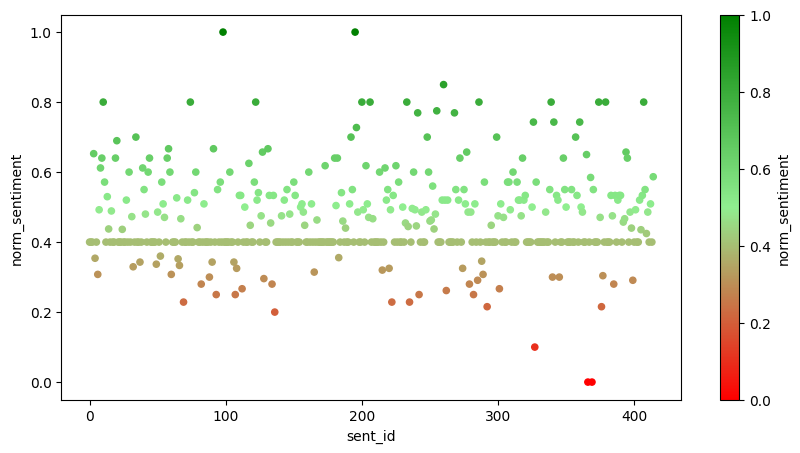

In [22]:
plot_sentiments('Anon_cqp_66.xml')

In [ ]:
#@title #### Select filenames to change the plot...{ run: "auto" }

choose_filename = 'Ostell_cqp_34.xml' #@param ['Anon_cqp_66.xml', 'Bree_cqp_56.xml', 'Carter_cqp_52.xml', 'Collingwood_cqp_75.xml', 'Denholm_cqp_35.xml', 'Gell_cqp_29.xml', 'Hawthorne_cqp_70.xml','Ostell_cqp_34.xml', 'Southey_cqp_40.xml', 'Walker_cqp_25.xml'] {allow-input: true}

plot_sentiments(choose_filename)

### Further ideas for the data tables

With the data tables (or data frames), you can attempt write codes that can query, extract and visualise your data in different ways e.g.:

*   Top placenames in a file
*   Top geonouns in a file
*   Top co-occurring geonouns to a place name
*   Search for sentences with specific placenames or geonouns or any combination of both

Also, the datasets form the basis for training a more complex machine learning models

